# Как закалялась сталь?

## Введение

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» хочет уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

**План работы**

1. Обработка данных до начала иследования

- Во избежание утечки жанных может использоваться только начальная температура
- Данные по мощности агрегируются(суммарная мощность, средняя полная мощноть, средняя активная мощность, средняя реактивная мощность)
- Выбросы не удаляются, кроме:температура ниже 1500 градусов, отрицательная мощность
- Из времени попробуем получить полное время нагрева.
- Пропуски можно заменить нулями

2. EDA 

- Строим графики
- Ищем закономенрности 
- генерируем дополнительные признаки

3. Премоделирование

- создаем пайплайн
- для линейных моделей включаем масштабирование(проверка на коллинеарность)
- CV через randomizedgridserch 
- выборку делим в пропорции 1 к 3.
- метрика мае

3. Моделирование

- используем ридж, лес, SVC  и бустинг
- проверка на адекватность через dummy модель

4. Тестирование победившей модели

5. Вывод, отчет и оформление.

**Описание технологии**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Обработка даннных

In [1]:
#!pip install skimpy

### Import

In [2]:
# import section

# modules
import os
import pandas as pd
import numpy as np
from skimpy import clean_columns
from phik import report, phik_matrix
from pandas_profiling import ProfileReport

#plot
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# модели
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyRegressor
import catboost as cb

# pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropCorrelatedFeatures, SmartCorrelatedSelection
from sklearn.ensemble import IsolationForest
from imblearn import FunctionSampler
from feature_engine.outliers import OutlierTrimmer
from sklearn.feature_selection import mutual_info_classif, SelectKBest

#score

from sklearn.metrics import mean_absolute_error, get_scorer_names

# отключаем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [3]:
# loading datasets

files = os.listdir('datasets/final_steel/')
directory = 'datasets/final_steel/'
files

['.DS_Store',
 'data_arc.csv',
 'data_bulk.csv',
 'data_bulk_time.csv',
 'data_gas.csv',
 'data_temp.csv',
 'data_wire.csv',
 'data_wire_time.csv']

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

In [4]:
# creating a dict structure for a work simplification
df = {k[:-4]: pd.read_csv(directory + k, 
                          index_col='key') for k in files[1:]}

In [5]:
# base info
for k,v in zip(df.keys(), df.values()):
    display(k)
    display(v.head())
    display(v.info())
    display(v.describe().T)

'data_arc'

Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
key                                                                
1    2019-05-03 11:02:14  2019-05-03 11:06:02           0.976059   
1    2019-05-03 11:07:28  2019-05-03 11:10:33           0.805607   
1    2019-05-03 11:11:44  2019-05-03 11:14:36           0.744363   
1    2019-05-03 11:18:14  2019-05-03 11:24:19           1.659363   
1    2019-05-03 11:26:09  2019-05-03 11:28:37           0.692755   

     Реактивная мощность  
key                       
1               0.687084  
1               0.520285  
1               0.498805  
1               1.062669  
1               0.414397

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14876 entries, 1 to 3241
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Начало нагрева дугой  14876 non-null  object 
 1   Конец нагрева дугой   14876 non-null  object 
 2   Активная мощность     14876 non-null  float64
 3   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), object(2)
memory usage: 581.1+ KB


None

count      mean       std         min       25%  \
Активная мощность    14876.0  0.670441  0.408159    0.030002  0.395297   
Реактивная мощность  14876.0  0.452592  5.878702 -715.504924  0.290991   

                          50%       75%       max  
Активная мощность    0.555517  0.857034  3.731596  
Реактивная мощность  0.415962  0.637371  2.676388

'data_bulk'

Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  Bulk 9  \
key                                                                           
1       NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN     NaN   
2       NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN     NaN   
3       NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN     NaN   
4       NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN     NaN   
5       NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN     NaN   

     Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
key                                                        
1        NaN      NaN    206.0      NaN    150.0    154.0  
2        NaN      NaN    206.0      NaN    149.0    154.0  
3        NaN      NaN    205.0      NaN    152.0    153.0  
4        NaN      NaN    207.0      NaN    153.0    154.0  
5        NaN      NaN    203.0      NaN    151.0    152.0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Bulk 1   252 non-null    float64
 1   Bulk 2   22 non-null     float64
 2   Bulk 3   1298 non-null   float64
 3   Bulk 4   1014 non-null   float64
 4   Bulk 5   77 non-null     float64
 5   Bulk 6   576 non-null    float64
 6   Bulk 7   25 non-null     float64
 7   Bulk 8   1 non-null      float64
 8   Bulk 9   19 non-null     float64
 9   Bulk 10  176 non-null    float64
 10  Bulk 11  177 non-null    float64
 11  Bulk 12  2450 non-null   float64
 12  Bulk 13  18 non-null     float64
 13  Bulk 14  2806 non-null   float64
 14  Bulk 15  2248 non-null   float64
dtypes: float64(15)
memory usage: 391.1 KB


None

count        mean         std    min     25%    50%     75%     max
Bulk 1    252.0   39.242063   18.277654   10.0   27.00   31.0   46.00   185.0
Bulk 2     22.0  253.045455   21.180578  228.0  242.00  251.5  257.75   325.0
Bulk 3   1298.0  113.879045   75.483494    6.0   58.00   97.5  152.00   454.0
Bulk 4   1014.0  104.394477   48.184126   12.0   72.00  102.0  133.00   281.0
Bulk 5     77.0  107.025974   81.790646   11.0   70.00   86.0  132.00   603.0
Bulk 6    576.0  118.925347   72.057776   17.0   69.75  100.0  157.00   503.0
Bulk 7     25.0  305.600000  191.022904   47.0  155.00  298.0  406.00   772.0
Bulk 8      1.0   49.000000         NaN   49.0   49.00   49.0   49.00    49.0
Bulk 9     19.0   76.315789   21.720581   63.0   66.00   68.0   70.50   147.0
Bulk 10   176.0   83.284091   26.060347   24.0   64.00   86.5  102.00   159.0
Bulk 11   177.0   76.819209   59.655365    8.0   25.00   64.0  106.00   313.0
Bulk 12  2450.0  260.471020  120.649269   53.0  204.00  208.0  316.00  1849.0
Bulk 13    18.0  181.111111   46.088009  151.0  153.25  155.5  203.50   305.0
Bulk 14  2806.0  170.284747   65.868652   16.0  119.00  151.0  205.75   636.0
Bulk 15  2248.0  160.513345   51.765319    1.0  105.00  160.0  205.00   405.0

'data_bulk_time'

Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
key                                                                         
1      NaN    NaN    NaN  2019-05-03 11:21:30    NaN    NaN    NaN    NaN   
2      NaN    NaN    NaN  2019-05-03 11:46:38    NaN    NaN    NaN    NaN   
3      NaN    NaN    NaN  2019-05-03 12:31:06    NaN    NaN    NaN    NaN   
4      NaN    NaN    NaN  2019-05-03 12:48:43    NaN    NaN    NaN    NaN   
5      NaN    NaN    NaN  2019-05-03 13:18:50    NaN    NaN    NaN    NaN   

    Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
key                                                                            
1      NaN     NaN     NaN  2019-05-03 11:03:52     NaN  2019-05-03 11:03:52   
2      NaN     NaN     NaN  2019-05-03 11:40:20     NaN  2019-05-03 11:40:20   
3      NaN     NaN     NaN  2019-05-03 12:09:40     NaN  2019-05-03 12:09:40   
4      NaN     NaN     NaN  2019-05-03 12:41:24     NaN  2019-05-03 12:41:24   
5      NaN     NaN     NaN  2019-05-03 13:12:56     NaN  2019-05-03 13:12:56   

                 Bulk 15  
key                       
1    2019-05-03 11:03:52  
2    2019-05-03 11:40:20  
3    2019-05-03 12:09:40  
4    2019-05-03 12:41:24  
5    2019-05-03 13:12:56

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Bulk 1   252 non-null    object
 1   Bulk 2   22 non-null     object
 2   Bulk 3   1298 non-null   object
 3   Bulk 4   1014 non-null   object
 4   Bulk 5   77 non-null     object
 5   Bulk 6   576 non-null    object
 6   Bulk 7   25 non-null     object
 7   Bulk 8   1 non-null      object
 8   Bulk 9   19 non-null     object
 9   Bulk 10  176 non-null    object
 10  Bulk 11  177 non-null    object
 11  Bulk 12  2450 non-null   object
 12  Bulk 13  18 non-null     object
 13  Bulk 14  2806 non-null   object
 14  Bulk 15  2248 non-null   object
dtypes: object(15)
memory usage: 391.1+ KB


None

count unique                  top freq
Bulk 1    252    252  2019-05-03 17:50:19    1
Bulk 2     22     22  2019-05-07 08:36:19    1
Bulk 3   1298   1298  2019-05-03 20:13:36    1
Bulk 4   1014   1014  2019-05-03 11:21:30    1
Bulk 5     77     77  2019-05-07 08:36:19    1
Bulk 6    576    576  2019-05-03 18:52:57    1
Bulk 7     25     25  2019-05-07 11:37:42    1
Bulk 8      1      1  2019-07-05 17:46:11    1
Bulk 9     19     19  2019-05-14 00:04:56    1
Bulk 10   176    176  2019-05-06 01:36:24    1
Bulk 11   177    177  2019-05-05 16:45:05    1
Bulk 12  2450   2450  2019-05-03 11:03:52    1
Bulk 13    18     18  2019-05-05 00:39:35    1
Bulk 14  2806   2806  2019-05-03 11:03:52    1
Bulk 15  2248   2248  2019-05-03 11:03:52    1

'data_gas'

Газ 1
key           
1    29.749986
2    12.555561
3    28.554793
4    18.841219
5     5.413692

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3239 entries, 1 to 3241
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Газ 1   3239 non-null   float64
dtypes: float64(1)
memory usage: 50.6 KB


None

count       mean       std       min       25%       50%        75%  \
Газ 1  3239.0  11.002062  6.220327  0.008399  7.043089  9.836267  13.769915   

            max  
Газ 1  77.99504

'data_temp'

Время замера  Температура
key                                  
1    2019-05-03 11:16:18       1571.0
1    2019-05-03 11:25:53       1604.0
1    2019-05-03 11:29:11       1618.0
1    2019-05-03 11:30:01       1601.0
1    2019-05-03 11:30:39       1613.0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15907 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Время замера  15907 non-null  object 
 1   Температура   13006 non-null  float64
dtypes: float64(1), object(1)
memory usage: 372.8+ KB


None

count        mean        std     min     25%     50%     75%  \
Температура  13006.0  1591.84092  21.375851  1191.0  1581.0  1591.0  1601.0   

                max  
Температура  1705.0

'data_wire'

Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
key                                                                       
1    60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5    89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

     Wire 9  
key          
1       NaN  
2       NaN  
3       NaN  
4       NaN  
5       NaN

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Wire 1  3055 non-null   float64
 1   Wire 2  1079 non-null   float64
 2   Wire 3  63 non-null     float64
 3   Wire 4  14 non-null     float64
 4   Wire 5  1 non-null      float64
 5   Wire 6  73 non-null     float64
 6   Wire 7  11 non-null     float64
 7   Wire 8  19 non-null     float64
 8   Wire 9  29 non-null     float64
dtypes: float64(9)
memory usage: 240.7 KB


None

count        mean        std        min        25%         50%  \
Wire 1  3055.0  100.895853  42.012518   1.918800  72.115684  100.158234   
Wire 2  1079.0   50.577323  39.320216   0.030160  20.193680   40.142956   
Wire 3    63.0  189.482681  99.513444   0.144144  95.135044  235.194977   
Wire 4    14.0   57.442841  28.824667  24.148801  40.807002   45.234282   
Wire 5     1.0   15.132000        NaN  15.132000  15.132000   15.132000   
Wire 6    73.0   48.016974  33.919845   0.034320  25.053600   42.076324   
Wire 7    11.0   10.039007   8.610584   0.234208   6.762756    9.017009   
Wire 8    19.0   53.625193  16.881728  45.076721  46.094879   46.279999   
Wire 9    29.0   34.155752  19.931616   4.622800  22.058401   30.066399   

               75%         max  
Wire 1  126.060483  330.314424  
Wire 2   70.227558  282.780152  
Wire 3  276.252014  385.008668  
Wire 4   76.124619  113.231044  
Wire 5   15.132000   15.132000  
Wire 6   64.212723  180.454575  
Wire 7   11.886057   32.847674  
Wire 8   48.089603  102.762401  
Wire 9   43.862003   90.053604

'data_wire_time'

Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
key                                                                         
1    2019-05-03 11:11:41                  NaN    NaN    NaN    NaN    NaN   
2    2019-05-03 11:46:10                  NaN    NaN    NaN    NaN    NaN   
3    2019-05-03 12:13:47                  NaN    NaN    NaN    NaN    NaN   
4    2019-05-03 12:48:05                  NaN    NaN    NaN    NaN    NaN   
5    2019-05-03 13:18:15  2019-05-03 13:32:06    NaN    NaN    NaN    NaN   

    Wire 7 Wire 8 Wire 9  
key                       
1      NaN    NaN    NaN  
2      NaN    NaN    NaN  
3      NaN    NaN    NaN  
4      NaN    NaN    NaN  
5      NaN    NaN    NaN

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Wire 1  3055 non-null   object
 1   Wire 2  1079 non-null   object
 2   Wire 3  63 non-null     object
 3   Wire 4  14 non-null     object
 4   Wire 5  1 non-null      object
 5   Wire 6  73 non-null     object
 6   Wire 7  11 non-null     object
 7   Wire 8  19 non-null     object
 8   Wire 9  29 non-null     object
dtypes: object(9)
memory usage: 240.7+ KB


None

count unique                  top freq
Wire 1  3055   3055  2019-05-03 11:11:41    1
Wire 2  1079   1079  2019-05-03 13:32:06    1
Wire 3    63     63  2019-05-04 04:47:53    1
Wire 4    14     14  2019-05-07 08:48:23    1
Wire 5     1      1  2019-08-08 16:01:07    1
Wire 6    73     73  2019-05-07 08:37:20    1
Wire 7    11     11  2019-07-23 12:42:00    1
Wire 8    19     19  2019-05-14 00:03:32    1
Wire 9    29     29  2019-05-04 16:09:11    1

In [6]:
# clean column names(dict.values() didn't work in cycle for unknown reason)
for k in df.keys():
    df[k] = clean_columns(df[k], replace={
        'Начало нагрева дугой': 'heat_start',
        'Конец нагрева дугой': 'heat_end',
        'Реактивная мощность': 'power_q',
        'Активная мощность': 'power_r',
        'Газ 1': 'gas',
        'Время замера': 'probe_time',
        'Температура': 'temp'
    })
    display(df[k].head(0))

4 column names have been cleaned

Empty DataFrame
Columns: [heat_start, heat_end, power_r, power_q]
Index: []

15 column names have been cleaned

Empty DataFrame
Columns: [bulk_1, bulk_2, bulk_3, bulk_4, bulk_5, bulk_6, bulk_7, bulk_8, bulk_9, bulk_10, bulk_11, bulk_12, bulk_13, bulk_14, bulk_15]
Index: []

15 column names have been cleaned

Empty DataFrame
Columns: [bulk_1, bulk_2, bulk_3, bulk_4, bulk_5, bulk_6, bulk_7, bulk_8, bulk_9, bulk_10, bulk_11, bulk_12, bulk_13, bulk_14, bulk_15]
Index: []

1 column names have been cleaned

Empty DataFrame
Columns: [gas]
Index: []

2 column names have been cleaned

Empty DataFrame
Columns: [probe_time, temp]
Index: []

9 column names have been cleaned

Empty DataFrame
Columns: [wire_1, wire_2, wire_3, wire_4, wire_5, wire_6, wire_7, wire_8, wire_9]
Index: []

9 column names have been cleaned

Empty DataFrame
Columns: [wire_1, wire_2, wire_3, wire_4, wire_5, wire_6, wire_7, wire_8, wire_9]
Index: []

### Отбор партий

В финальную таблицу попадют только те ключи которые есть во всех таблицах.

#### Отбор температуры

Предварительно скопируем датасет для исследования. Выделим последнюю температуру в партии, как таргет. В датасете оставим только первую температуру партии.  Удалим температуру ниже 1500 градусов.

In [7]:
#change probe_time type to datetime
df['data_temp']['probe_time'] = pd.to_datetime(df['data_temp']['probe_time'])

In [8]:
#check
df['data_temp'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15907 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   probe_time  15907 non-null  datetime64[ns]
 1   temp        13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 372.8 KB


In [9]:
#copy dataset and check
df_temp_research = df['data_temp'].copy()
df_temp_research.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15907 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   probe_time  15907 non-null  datetime64[ns]
 1   temp        13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 372.8 KB


In [10]:
#check if data is accending in all keys
df['data_temp']['next'] = df['data_temp']['probe_time'].shift()
df['data_temp']['ismore'] = df['data_temp']['probe_time'] - df['data_temp']['next']

In [11]:
df_negative_time_temp_probe = df['data_temp'][df['data_temp']['ismore'] / np.timedelta64(1, "s") < 0]
# save batch numbers fo future
df_negative_time_temp_probe

probe_time    temp                next            ismore
key                                                                   
22   2019-05-04 03:59:46  1560.0 2019-05-04 04:19:16 -1 days +23:40:30
25   2019-05-04 06:25:39  1594.0 2019-05-04 06:59:55 -1 days +23:25:44
45   2019-05-04 23:06:36  1538.0 2019-05-05 01:13:17 -1 days +21:53:19
46   2019-05-04 23:54:43  1607.0 2019-05-05 00:26:13 -1 days +23:28:30
47   2019-05-05 01:17:00  1565.0 2019-05-05 03:14:53 -1 days +22:02:07
...                  ...     ...                 ...               ...
3120 2019-08-28 04:12:21  1578.0 2019-08-28 06:04:21 -1 days +22:08:00
3121 2019-08-28 05:31:29  1556.0 2019-08-28 06:56:24 -1 days +22:35:05
3182 2019-08-30 06:06:37  1563.0 2019-08-30 06:55:57 -1 days +23:10:40
3213 2019-08-31 05:05:01  1595.0 2019-08-31 06:20:55 -1 days +22:44:06
3216 2019-08-31 06:30:48  1596.0 2019-08-31 07:26:11 -1 days +23:04:37

[105 rows x 4 columns]

Выборочно посмотрим на несколько партий попавших в список с отрицательной дельтой по времени.

In [12]:
df['data_temp'][df['data_temp'].index == 21]

probe_time    temp                next          ismore
key                                                                
21  2019-05-04 03:25:47  1603.0 2019-05-04 02:07:18 0 days 01:18:29
21  2019-05-04 03:26:23  1579.0 2019-05-04 03:25:47 0 days 00:00:36
21  2019-05-04 03:33:13  1581.0 2019-05-04 03:26:23 0 days 00:06:50
21  2019-05-04 03:46:00  1626.0 2019-05-04 03:33:13 0 days 00:12:47
21  2019-05-04 03:51:04  1617.0 2019-05-04 03:46:00 0 days 00:05:04
21  2019-05-04 03:52:22  1615.0 2019-05-04 03:51:04 0 days 00:01:18
21  2019-05-04 04:10:40  1609.0 2019-05-04 03:52:22 0 days 00:18:18
21  2019-05-04 04:15:17  1623.0 2019-05-04 04:10:40 0 days 00:04:37
21  2019-05-04 04:19:16  1618.0 2019-05-04 04:15:17 0 days 00:03:59

In [13]:
df['data_temp'][df['data_temp'].index == 22]

probe_time    temp                next            ismore
key                                                                  
22  2019-05-04 03:59:46  1560.0 2019-05-04 04:19:16 -1 days +23:40:30
22  2019-05-04 04:29:49  1563.0 2019-05-04 03:59:46   0 days 00:30:03
22  2019-05-04 04:41:06  1594.0 2019-05-04 04:29:49   0 days 00:11:17
22  2019-05-04 04:48:27  1598.0 2019-05-04 04:41:06   0 days 00:07:21
22  2019-05-04 04:49:05  1597.0 2019-05-04 04:48:27   0 days 00:00:38
22  2019-05-04 04:50:36  1593.0 2019-05-04 04:49:05   0 days 00:01:31

In [14]:
df['data_temp'][df['data_temp'].index == 3216]

probe_time    temp                next            ismore
key                                                                   
3216 2019-08-31 06:30:48  1596.0 2019-08-31 07:26:11 -1 days +23:04:37
3216 2019-08-31 06:33:59     NaN 2019-08-31 06:30:48   0 days 00:03:11
3216 2019-08-31 06:36:12     NaN 2019-08-31 06:33:59   0 days 00:02:13
3216 2019-08-31 06:40:06     NaN 2019-08-31 06:36:12   0 days 00:03:54
3216 2019-08-31 06:40:38     NaN 2019-08-31 06:40:06   0 days 00:00:32
3216 2019-08-31 06:41:07     NaN 2019-08-31 06:40:38   0 days 00:00:29
3216 2019-08-31 06:41:57     NaN 2019-08-31 06:41:07   0 days 00:00:50
3216 2019-08-31 06:44:33     NaN 2019-08-31 06:41:57   0 days 00:02:36

Существуют партии в которых первый замер темпратуры по времени раньше, чем последний замер в предыдущей партии. 

In [15]:
# check if negative timedalta exists within one batch
len(df_negative_time_temp_probe.index.unique())

105

Исследование показывает, что в пределах одной партии замеры отсортированы по возрастанию времени замера. Это означает, что можно использовать функции first и last для выбора первого и аоследнего замеров в партиях.

In [16]:
temp_df1 = df['data_temp'].reset_index()
temp_df1.drop(['probe_time', 'next', 'ismore'], axis=1, inplace=True)
temp_df1.fillna(0, inplace=True)

In [17]:
# take the first and the last probe
df_first_temp = temp_df1.groupby(by=temp_df1.key).first()
df_last_temp = temp_df1.groupby(by=temp_df1.key).last()

In [18]:
# check the lenth
display(df_first_temp.shape, df_last_temp.shape)

(3216, 1)

(3216, 1)

In [19]:
# joining datasets
df['data_temp'] = df_first_temp.join(df_last_temp, lsuffix='_first', rsuffix='_last')

In [20]:
# check
df['data_temp']

temp_first  temp_last
key                        
1         1571.0     1613.0
2         1581.0     1602.0
3         1596.0     1599.0
4         1601.0     1625.0
5         1576.0     1602.0
...          ...        ...
3237      1569.0        0.0
3238      1584.0        0.0
3239      1598.0        0.0
3240      1617.0        0.0
3241      1586.0        0.0

[3216 rows x 2 columns]

In [21]:
# dropping row if las temp is Nan.
df['data_temp'].drop(df['data_temp'][df['data_temp']['temp_last'] == 0].index, inplace=True)

In [22]:
df['data_temp']

temp_first  temp_last
key                        
1         1571.0     1613.0
2         1581.0     1602.0
3         1596.0     1599.0
4         1601.0     1625.0
5         1576.0     1602.0
...          ...        ...
2495      1570.0     1591.0
2496      1554.0     1591.0
2497      1571.0     1589.0
2498      1591.0     1594.0
2499      1569.0     1603.0

[2477 rows x 2 columns]

Получили таблицу с первым и последним измерениями температуры

#### Data ark

Удалим отрицательные значения мощности и посмотрим статистику по суммарной мощности

In [23]:
df['data_arc'].drop(df['data_arc'][df['data_arc']['power_q'] < 0].index,axis=0, inplace=True)

In [24]:
fig = px.box(df['data_arc'][['power_r']].groupby(by='key').sum())
fig.show()

In [25]:
temp_df = df['data_arc'][['power_r']].groupby(by='key').sum()

In [26]:
# outliers rate
temp_df[temp_df['power_r'] > 6.529].count()/temp_df.count()

power_r    0.015251
dtype: float64

In [27]:
fig = px.box(df['data_arc'][['power_q']].groupby(by='key').sum())
fig.show()

In [28]:
temp_df = df['data_arc'][['power_q']].groupby(by='key').sum()
# outliers rate
temp_df[temp_df['power_q'] > 4.835].count()/temp_df.count()

power_q    0.01774
dtype: float64

Количество выбросов минимкльно по условию задачи они не удаляются

Сформируем столбцы со средней, сумарной, полной мощностью.

In [29]:
# change to datime
df['data_arc']['heat_start'] = pd.to_datetime(df['data_arc']['heat_start'])

In [30]:
# change to datime
df['data_arc']['heat_end'] = pd.to_datetime(df['data_arc']['heat_end'])

In [31]:
# check
df['data_arc'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14872 entries, 1 to 3241
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   heat_start  14872 non-null  datetime64[ns]
 1   heat_end    14872 non-null  datetime64[ns]
 2   power_r     14872 non-null  float64       
 3   power_q     14872 non-null  float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 580.9 KB


In [32]:
# crating a duration column
df['data_arc']['duration'] = (df['data_arc']['heat_end'] - df['data_arc']['heat_start']) / np.timedelta64(1, "s")

In [33]:
# crating a full power column
df['data_arc']['full_p'] = df['data_arc'].agg(lambda x: np.sqrt(x['power_r'] ** 2 + x['power_q'] ** 2), axis=1)

In [34]:
#check
df['data_arc'].head(1)

heat_start            heat_end   power_r   power_q  duration  \
key                                                                         
1   2019-05-03 11:02:14 2019-05-03 11:06:02  0.976059  0.687084     228.0   

       full_p  
key            
1    1.193639

In [35]:
# copy df for future eda
df_arc_research = df['data_arc'].copy()

In [36]:
# droping the datime
df['data_arc'].drop(['heat_start', 'heat_end'], axis=1, inplace=True)

In [37]:
# grouping by key
df['data_arc'] = df['data_arc'].groupby(by='key').agg([np.sum, 
                                       np.mean,
                                     ])

In [38]:
# renaming the columns
df['data_arc'].columns = [i[0] + '_' + i[1] for i in df['data_arc'].columns]

In [39]:
#check
df['data_arc'].head(1)

power_r_sum  power_r_mean  power_q_sum  power_q_mean  duration_sum  \
key                                                                       
1       4.878147      0.975629     3.183241      0.636648        1098.0   

     duration_mean  full_p_sum  full_p_mean  
key                                          
1            219.6    5.826395     1.165279

#### Data bulk

In [40]:
df['data_bulk']['vec'] = ''

In [41]:
def make_vec(row):
    s=''
    for i in row[:-1]:
        if i > 0:
            s += '1'
        else:
            s += '0'
    return s


In [42]:
df['data_bulk']['vec'] = df['data_bulk'].apply(make_vec, axis=1)

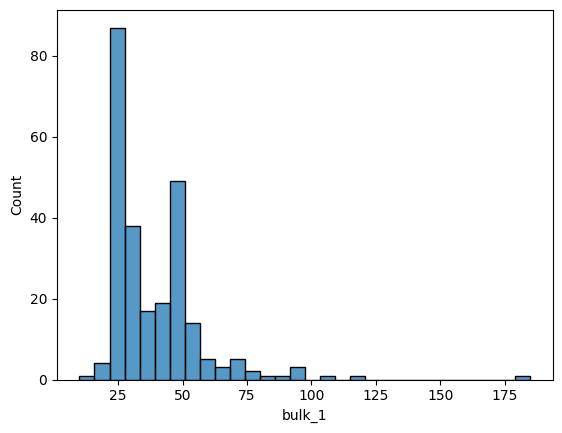

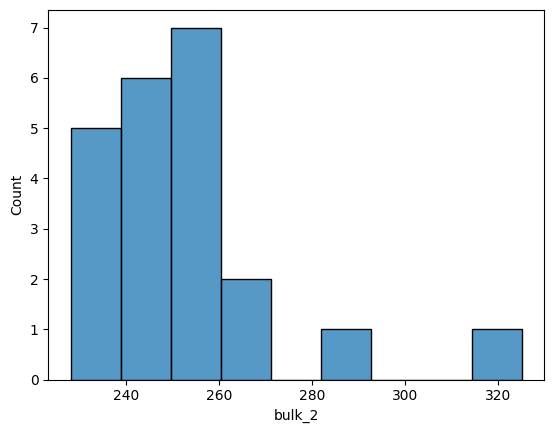

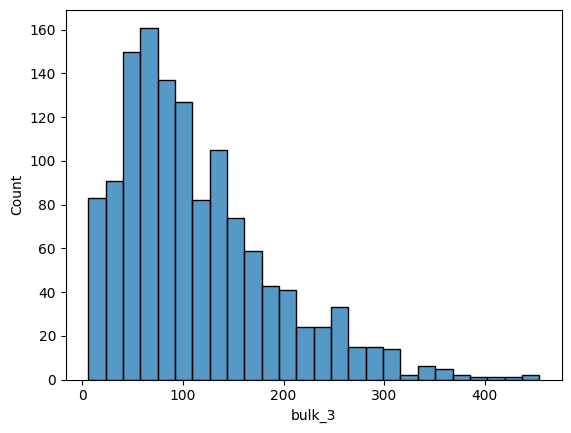

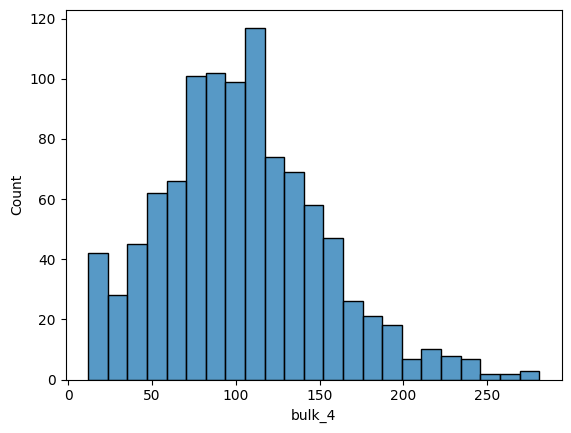

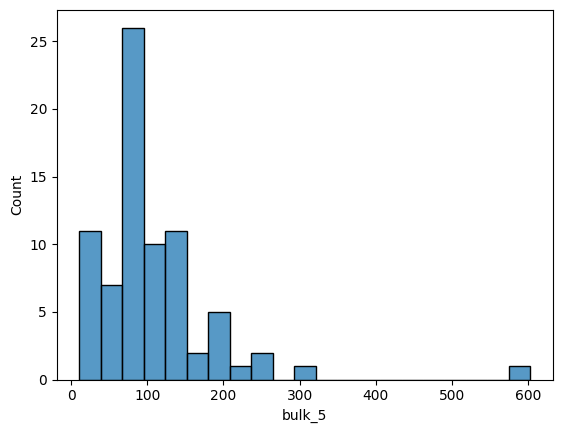

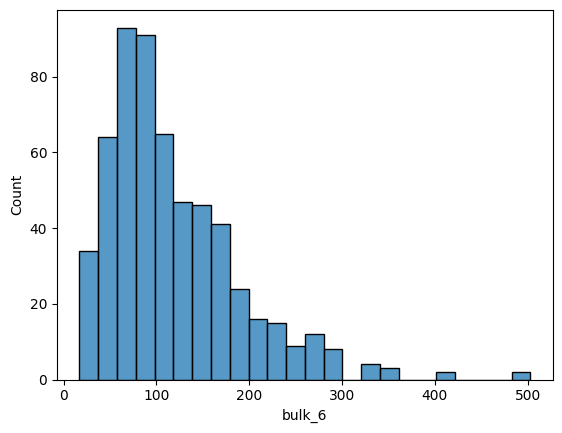

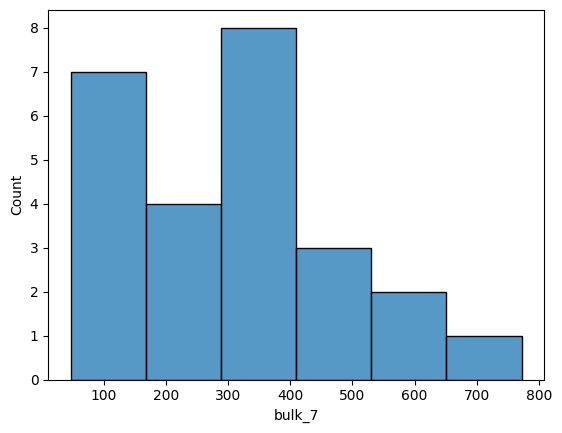

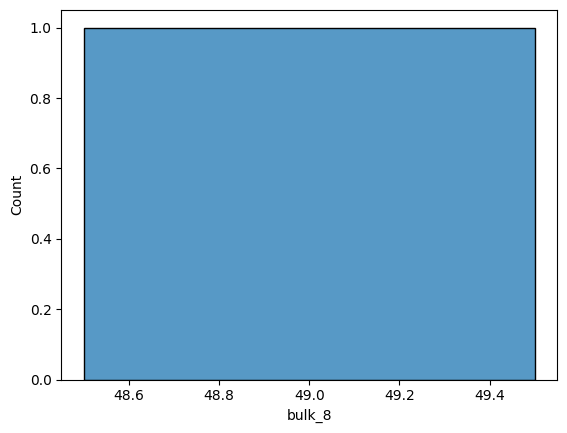

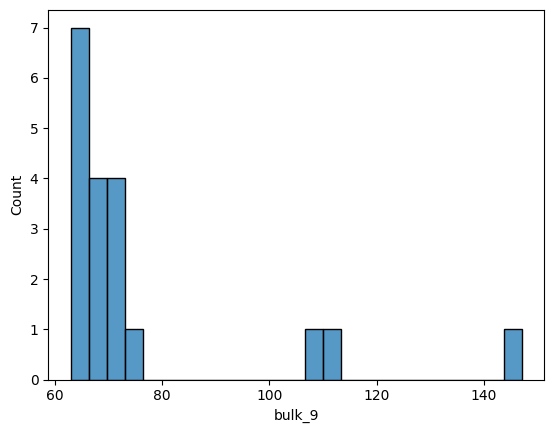

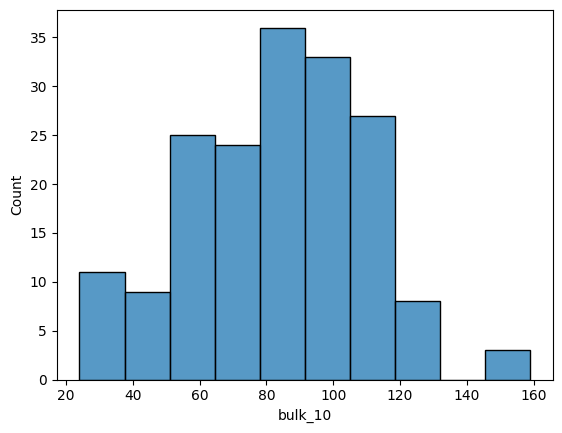

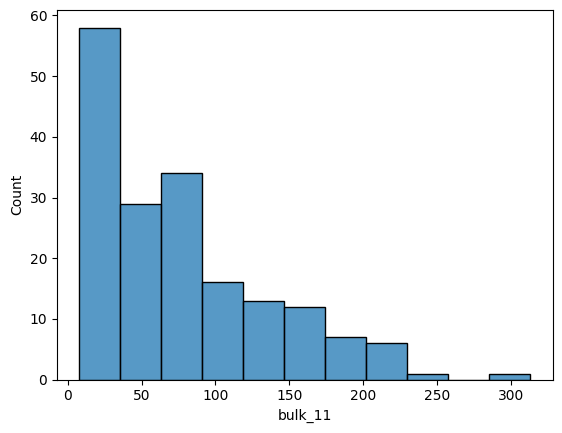

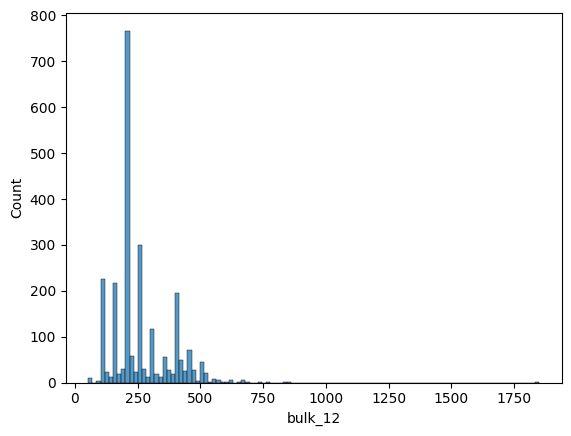

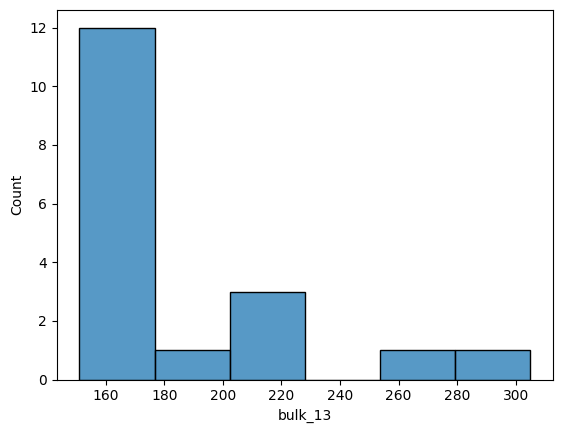

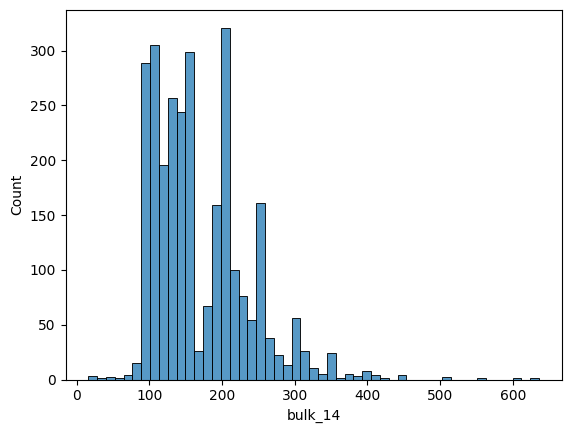

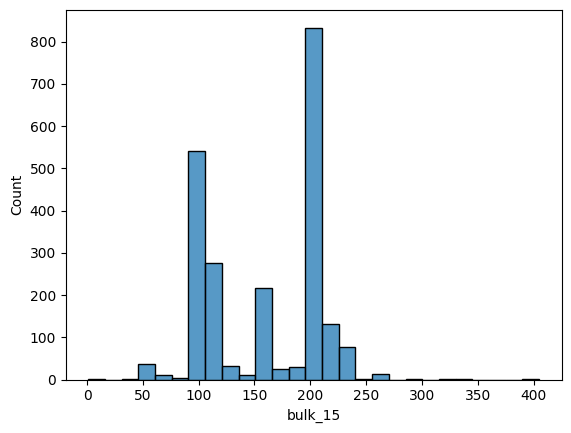

In [43]:
for i in df['data_bulk'].columns[:-1]:
    plt.figure()
    sns.histplot(data=df['data_bulk'][i]);

In [44]:
df['data_bulk'].head(3)

bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_8  bulk_9  \
key                                                                           
1       NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN     NaN   
2       NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN     NaN   
3       NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN     NaN   

     bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15              vec  
key                                                                         
1        NaN      NaN    206.0      NaN    150.0    154.0  000100000001011  
2        NaN      NaN    206.0      NaN    149.0    154.0  000100000001011  
3        NaN      NaN    205.0      NaN    152.0    153.0  000100000001011

In [45]:
df_temp_data_ark = df['data_bulk'].groupby('vec').count()
df_temp_data_ark

bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  \
vec                                                                       
000000000000010       0       0       0       0       0       0       0   
000000000000011       0       0       0       0       0       0       0   
000000000001000       0       0       0       0       0       0       0   
000000000001010       0       0       0       0       0       0       0   
000000000001011       0       0       0       0       0       0       0   
...                 ...     ...     ...     ...     ...     ...     ...   
110010100000000       1       1       0       0       1       0       1   
110110000000000       4       4       0       4       4       0       0   
110110100000000      12      12       0      12      12       0      12   
110110100001000       1       1       0       1       1       0       1   
110110100010000       1       1       0       1       1       0       1   

                 bulk_8  bulk_9  bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  \
vec                                                                            
000000000000010       0       0        0        0        0        0       51   
000000000000011       0       0        0        0        0        0        9   
000000000001000       0       0        0        0       10        0        0   
000000000001010       0       0        0        0       95        0       95   
000000000001011       0       0        0        0      291        0      291   
...                 ...     ...      ...      ...      ...      ...      ...   
110010100000000       0       0        0        0        0        0        0   
110110000000000       0       0        0        0        0        0        0   
110110100000000       0       0        0        0        0        0        0   
110110100001000       0       0        0        0        1        0        0   
110110100010000       0       0        0        1        0        0        0   

                 bulk_15  
vec                       
000000000000010        0  
000000000000011        9  
000000000001000        0  
000000000001010        0  
000000000001011      291  
...                  ...  
110010100000000        0  
110110000000000        0  
110110100000000        0  
110110100001000        0  
110110100010000        0  

[143 rows x 15 columns]

In [46]:
df_vec = df['data_bulk'].groupby('vec')['vec'].count().sort_values(ascending=False)

In [47]:
df_vec[df_vec > 100]

vec
001000000001011    575
000100000001011    527
000000000001011    291
000001000001011    143
001100000001011    109
000100000000000    102
Name: vec, dtype: int64

In [48]:
len(df_vec[df_vec < 2])

50

Всего 143 варианта подачи сыпучих материалов. Чаще всего используются bulk_12, bulk_14 и bulk_15 вместе или с доплнительными материалами. 50 вариантов подачи использовались только 1 раз.

#### Gas

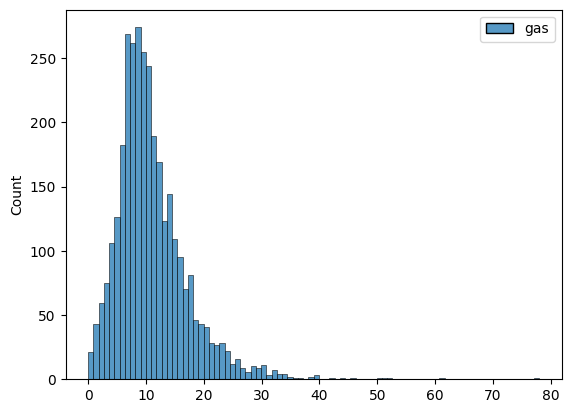

In [49]:
sns.histplot(data=df['data_gas']);

In [50]:
df['data_gas'].mean()

gas    11.002062
dtype: float64

#### Data wire

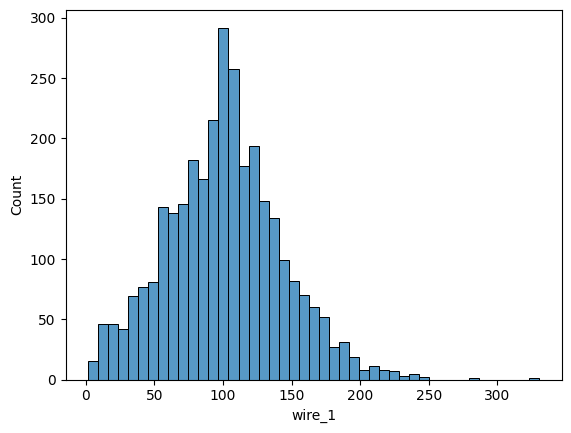

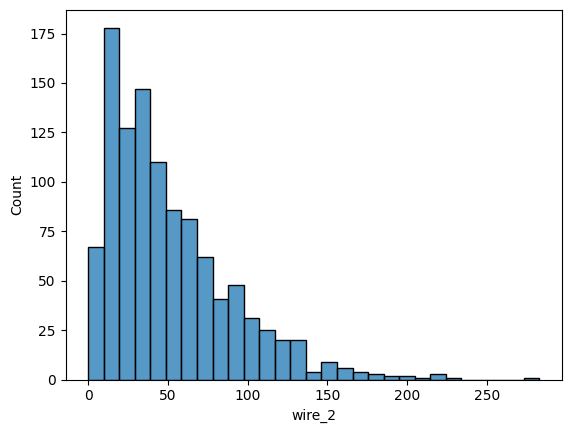

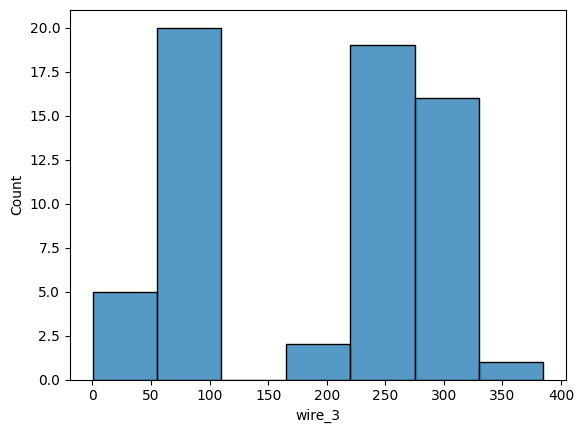

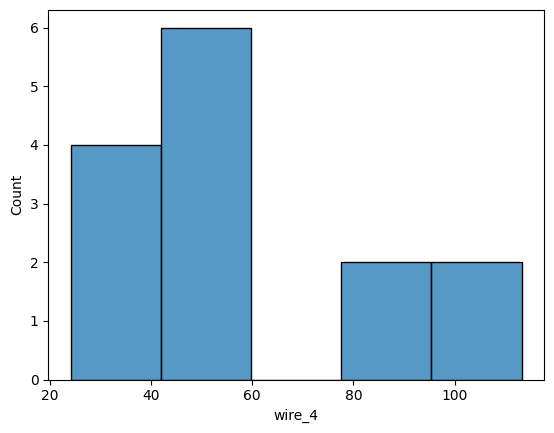

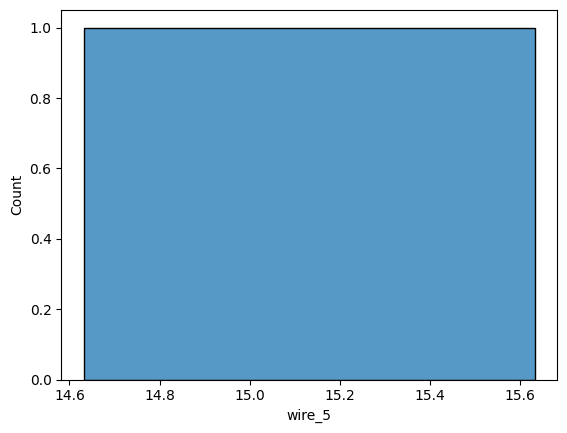

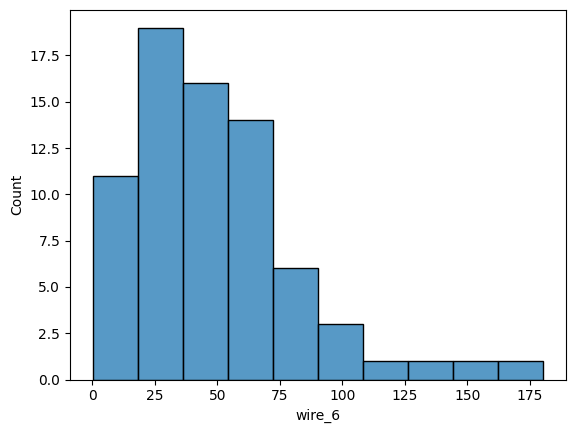

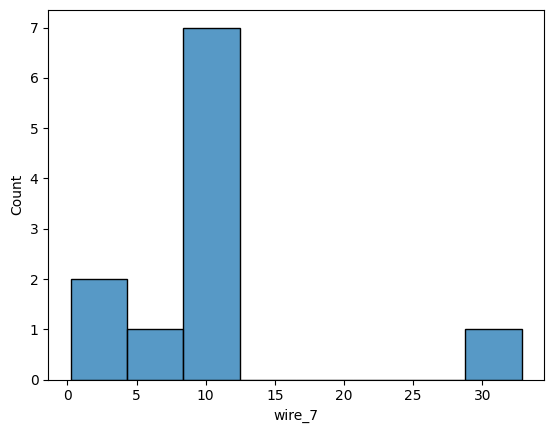

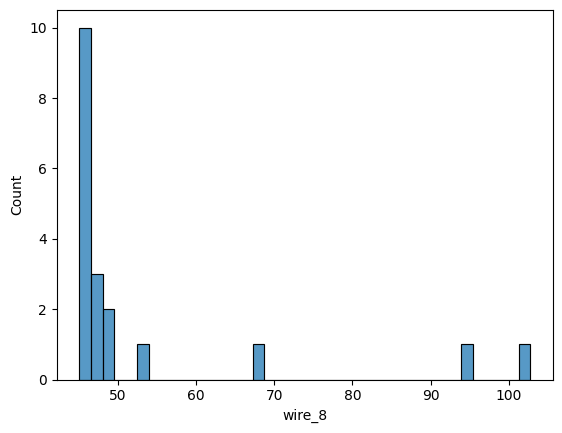

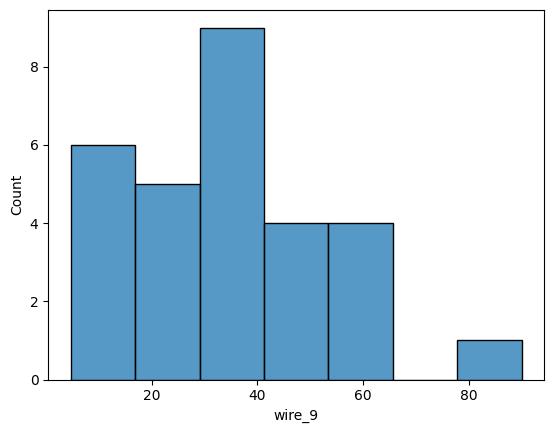

In [51]:
for i in df['data_wire'].columns:
    plt.figure()
    sns.histplot(data=df['data_wire'][i]);

In [52]:
df['data_wire']['vec'] = ''

In [53]:
df['data_wire']['vec'] = df['data_wire'].apply(make_vec, axis=1)

In [54]:
df['data_wire'].head(3)

wire_1  wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  \
key                                                                      
1    60.059998     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    96.052315     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    91.160157     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

     wire_9        vec  
key                     
1       NaN  100000000  
2       NaN  100000000  
3       NaN  100000000

In [55]:
df_temp_data_wire = df['data_wire'].groupby('vec').count()
df_temp_data_wire.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, 000000001 to 111000000
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   wire_1  24 non-null     int64
 1   wire_2  24 non-null     int64
 2   wire_3  24 non-null     int64
 3   wire_4  24 non-null     int64
 4   wire_5  24 non-null     int64
 5   wire_6  24 non-null     int64
 6   wire_7  24 non-null     int64
 7   wire_8  24 non-null     int64
 8   wire_9  24 non-null     int64
dtypes: int64(9)
memory usage: 1.9+ KB


In [56]:
df_vec_wire = df['data_wire'].groupby('vec')['vec'].count().sort_values(ascending=False)

In [57]:
df_vec_wire[df_vec_wire > 100]

vec
100000000    1917
110000000     985
Name: vec, dtype: int64

In [58]:
len(df_vec_wire[df_vec_wire < 2])

5

Всего 24 варианта подачи проволных материалов. Чаще всего используются wire_1 самостоятельно или с добавлением wire_2. 5 вариантов подачи использовались только 1 раз.

#### Data bulk time

In [59]:
#change to datime type
for i in df['data_bulk_time'].columns:
    df['data_bulk_time'][i] = pd.to_datetime(df['data_bulk_time'][i])

In [60]:
# get info to check
df['data_bulk_time'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   bulk_1   252 non-null    datetime64[ns]
 1   bulk_2   22 non-null     datetime64[ns]
 2   bulk_3   1298 non-null   datetime64[ns]
 3   bulk_4   1014 non-null   datetime64[ns]
 4   bulk_5   77 non-null     datetime64[ns]
 5   bulk_6   576 non-null    datetime64[ns]
 6   bulk_7   25 non-null     datetime64[ns]
 7   bulk_8   1 non-null      datetime64[ns]
 8   bulk_9   19 non-null     datetime64[ns]
 9   bulk_10  176 non-null    datetime64[ns]
 10  bulk_11  177 non-null    datetime64[ns]
 11  bulk_12  2450 non-null   datetime64[ns]
 12  bulk_13  18 non-null     datetime64[ns]
 13  bulk_14  2806 non-null   datetime64[ns]
 14  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15)
memory usage: 391.1 KB


In [61]:
# creating dataset for analis
data_bulk_time_dur = (df['data_bulk_time'].max(axis=1) - df['data_bulk_time'].min(axis=1)) / np.timedelta64(1, "s")

In [62]:
data_bulk_time_dur[data_bulk_time_dur == 0].count()

710

In [63]:
data_bulk_time_dur.mean()

576.5014381591562

In [64]:
px.box(data_bulk_time_dur[data_bulk_time_dur > 0],
            )

Большинство значений разницы во времени между подачей первого материала и последнего лежит между 359 и 906 секунд.

#### Data wire time

In [65]:
#change to datime type
for i in df['data_wire_time'].columns:
    df['data_wire_time'][i] = pd.to_datetime(df['data_wire_time'][i])

In [66]:
# get info to check
df['data_wire_time'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   wire_1  3055 non-null   datetime64[ns]
 1   wire_2  1079 non-null   datetime64[ns]
 2   wire_3  63 non-null     datetime64[ns]
 3   wire_4  14 non-null     datetime64[ns]
 4   wire_5  1 non-null      datetime64[ns]
 5   wire_6  73 non-null     datetime64[ns]
 6   wire_7  11 non-null     datetime64[ns]
 7   wire_8  19 non-null     datetime64[ns]
 8   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9)
memory usage: 240.7 KB


In [67]:
# creating dataset for analis
data_wire_time_dur = (df['data_wire_time'].max(axis=1) - df['data_wire_time'].min(axis=1)) / np.timedelta64(1, "s")

In [68]:
data_wire_time_dur

key
1         0.0
2         0.0
3         0.0
4         0.0
5       831.0
        ...  
3237      0.0
3238      0.0
3239      0.0
3240      0.0
3241      0.0
Length: 3081, dtype: float64

In [69]:
data_wire_time_dur[data_wire_time_dur == 0].count()

1937

In [70]:
data_wire_time_dur.mean()

159.20934761441092

In [71]:
px.box(data_wire_time_dur[data_wire_time_dur > 0],
            )

Большинство значений разницы во времени между подачей первого материала и последнего лежит между 69 и 658 секунд.

### Вывод

В первой части исследования были загружены и проанализированы данные. Названия столбцов были приведены к стандартному виду. Выбросы были удалены в случаях: температура ниже 1500 градусов, отрицательная мощность. 

Были отобраны ключи в которых присутствует начальная и конечная температуры. 

Таблица с мощностью электродов по каждому ключу была преобразована к виду: 	активная мощность сумарная, активная мощность средняя, реактивная мощность сумарная, реактивная мощность средняя, длительность сумарная, длительность средняя, полная мощность сумарная, полная мощность средняя.

Была проанализирована таблица с подачей сыпучих материалов. Всего 143 варианта подачи сыпучих материалов. Чаще всего используются bulk_12, bulk_14 и bulk_15 вместе или с доплнительными материалами. 50 вариантов подачи использовались только 1 раз.

Была проанализирована таблица газ. Среднее значение газа 11.

Таблица с подачей проволочных материалов. Всего 24 варианта подачи проволных материалов. Чаще всего используются wire_1 самостоятельно или с добавлением wire_2. 5 вариантов подачи использовались только 1 раз.

Таблица со временем подачи сыпучих материалов. Большинство значений разницы во времени между подачей первого материала и последнего лежит между 359 и 906 секунд. В дальнейшем исследовании надо обратить внимание на выбросы в разнице во времени подачи.

Таблица со временем подачи проволочных материалов. Большинство значений разницы во времени между подачей первого материала и последнего лежит между 69 и 658 секунд.
В дальнейшем исследовании надо обратить внимание на выбросы в разнице во времени подачи.

Можно переходить к следующему этапу. Предполагается сбор общей таблицы и ее исследование.

### Вопросы 

1. В некоторых партиях первый замер темпратуры по времени раньше, чем последний замер в предыдущей партии. Что делать с такими партиями? 

новые вопросы

2. В таблицах data_bulk_time и data_wire_time есть ключи с явно выбивающимся временем между подачей материалов. Что с такими делать? Я хотел столбцы с вычислениями разницы перенечти в общую таблицу.

## EDA

### Делаем общий датасет

In [72]:
df['data_temp'].shape, df['data_gas'].shape

((2477, 2), (3239, 1))

In [73]:
df_final = df['data_temp'].join([df['data_gas'], 
                                 df['data_arc'], 
                                 df['data_wire'].drop('vec', axis=1),
                                 df['data_bulk'].drop('vec', axis=1),
                                 data_bulk_time_dur,
                                 data_wire_time_dur
                                ], how='inner')

In [74]:
df_final

temp_first  temp_last        gas  power_r_sum  power_r_mean  \
key                                                                 
1         1571.0     1613.0  29.749986     4.878147      0.975629   
2         1581.0     1602.0  12.555561     3.052598      0.763150   
3         1596.0     1599.0  28.554793     2.525882      0.505176   
4         1601.0     1625.0  18.841219     3.209250      0.802313   
5         1576.0     1602.0   5.413692     3.347173      0.836793   
...          ...        ...        ...          ...           ...   
2495      1570.0     1591.0   7.125735     3.210690      0.802673   
2496      1554.0     1591.0   9.412616     4.203064      0.700511   
2497      1571.0     1589.0   6.271699     2.212379      0.737460   
2498      1591.0     1594.0  14.953657     3.408725      0.681745   
2499      1569.0     1603.0  11.336151     4.098431      1.024608   

      power_q_sum  power_q_mean  duration_sum  duration_mean  full_p_sum  ...  \
key                                                                       ...   
1        3.183241      0.636648        1098.0     219.600000    5.826395  ...   
2        1.998112      0.499528         811.0     202.750000    3.649216  ...   
3        1.599076      0.319815         655.0     131.000000    2.989534  ...   
4        2.060298      0.515074         741.0     185.250000    3.814962  ...   
5        2.252643      0.563161         869.0     217.250000    4.035758  ...   
...           ...           ...           ...            ...         ...  ...   
2495     2.360777      0.590194         723.0     180.750000    3.986869  ...   
2496     2.810185      0.468364         940.0     156.666667    5.057033  ...   
2497     1.851269      0.617090         569.0     189.666667    2.885017  ...   
2498     2.355428      0.471086         750.0     150.000000    4.143749  ...   
2499     2.777865      0.694466         883.0     220.750000    4.953010  ...   

      bulk_8  bulk_9  bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  \
key                                                                          
1        NaN     NaN      NaN      NaN    206.0      NaN    150.0    154.0   
2        NaN     NaN      NaN      NaN    206.0      NaN    149.0    154.0   
3        NaN     NaN      NaN      NaN    205.0      NaN    152.0    153.0   
4        NaN     NaN      NaN      NaN    207.0      NaN    153.0    154.0   
5        NaN     NaN      NaN      NaN    203.0      NaN    151.0    152.0   
...      ...     ...      ...      ...      ...      ...      ...      ...   
2495     NaN     NaN     90.0      NaN    256.0      NaN    129.0    223.0   
2496     NaN     NaN    122.0      NaN    256.0      NaN    129.0    226.0   
2497     NaN     NaN      NaN      NaN    230.0      NaN    124.0    226.0   
2498     NaN     NaN    101.0      NaN    206.0      NaN    129.0    207.0   
2499     NaN     NaN      NaN      NaN    233.0      NaN    126.0    227.0   

           0      1  
key                  
1     1058.0    0.0  
2      378.0    0.0  
3     1286.0    0.0  
4      439.0    0.0  
5      354.0  831.0  
...      ...    ...  
2495  1023.0    0.0  
2496   459.0    0.0  
2497   249.0   24.0  
2498   361.0    0.0  
2499   284.0   69.0  

[2328 rows x 37 columns]

In [75]:
# filling NA's with zeros
df_final.fillna(0, inplace=True)

In [76]:
# fixing wromg columns names
df_final.rename(columns={0: 'data_bulk_time_dur',
                        1: 'data_wire_time_dur'},
                       inplace=True)

Расссмотрим получившуюся таблицу. 

In [77]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 1 to 2499
Data columns (total 37 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temp_first          2328 non-null   float64
 1   temp_last           2328 non-null   float64
 2   gas                 2328 non-null   float64
 3   power_r_sum         2328 non-null   float64
 4   power_r_mean        2328 non-null   float64
 5   power_q_sum         2328 non-null   float64
 6   power_q_mean        2328 non-null   float64
 7   duration_sum        2328 non-null   float64
 8   duration_mean       2328 non-null   float64
 9   full_p_sum          2328 non-null   float64
 10  full_p_mean         2328 non-null   float64
 11  wire_1              2328 non-null   float64
 12  wire_2              2328 non-null   float64
 13  wire_3              2328 non-null   float64
 14  wire_4              2328 non-null   float64
 15  wire_5              2328 non-null   float64
 16  wire_6

### Матрица корреляции

In [78]:
fk_m = phik_matrix(df_final)

interval columns not set, guessing: ['temp_first', 'temp_last', 'gas', 'power_r_sum', 'power_r_mean', 'power_q_sum', 'power_q_mean', 'duration_sum', 'duration_mean', 'full_p_sum', 'full_p_mean', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'data_bulk_time_dur', 'data_wire_time_dur']


In [79]:
# list of korrelated features
fltrd = fk_m[(fk_m > 0.7) & (fk_m < 1.0)].dropna(how='all').dropna(how='all', axis=1)
fltrd

gas  power_r_sum  power_r_mean  power_q_sum  \
gas                      NaN          NaN           NaN          NaN   
power_r_sum              NaN          NaN           NaN     0.973850   
power_r_mean             NaN          NaN           NaN          NaN   
power_q_sum              NaN     0.973850           NaN          NaN   
power_q_mean             NaN          NaN      0.939598          NaN   
duration_sum             NaN     0.921407           NaN     0.928309   
duration_mean            NaN          NaN      0.948268          NaN   
full_p_sum               NaN     0.995433           NaN     0.983219   
full_p_mean              NaN          NaN      0.988754          NaN   
wire_2                   NaN          NaN           NaN          NaN   
wire_4                   NaN          NaN           NaN          NaN   
wire_6                   NaN          NaN           NaN          NaN   
wire_7                   NaN          NaN           NaN          NaN   
bulk_2                   NaN          NaN           NaN          NaN   
bulk_6                   NaN          NaN           NaN          NaN   
bulk_7                   NaN          NaN           NaN          NaN   
bulk_12             0.728239          NaN           NaN          NaN   
bulk_14             0.797166     0.848532           NaN     0.764210   
data_wire_time_dur       NaN          NaN           NaN          NaN   

                    power_q_mean  duration_sum  duration_mean  full_p_sum  \
gas                          NaN           NaN            NaN         NaN   
power_r_sum                  NaN      0.921407            NaN    0.995433   
power_r_mean            0.939598           NaN       0.948268         NaN   
power_q_sum                  NaN      0.928309            NaN    0.983219   
power_q_mean                 NaN           NaN       0.937038         NaN   
duration_sum                 NaN           NaN            NaN    0.951429   
duration_mean           0.937038           NaN            NaN         NaN   
full_p_sum                   NaN      0.951429            NaN         NaN   
full_p_mean             0.960685           NaN       0.957091         NaN   
wire_2                       NaN           NaN            NaN         NaN   
wire_4                       NaN           NaN            NaN         NaN   
wire_6                       NaN           NaN            NaN         NaN   
wire_7                       NaN           NaN            NaN         NaN   
bulk_2                       NaN           NaN            NaN         NaN   
bulk_6                       NaN           NaN            NaN         NaN   
bulk_7                       NaN           NaN            NaN         NaN   
bulk_12                      NaN           NaN            NaN         NaN   
bulk_14                      NaN           NaN            NaN    0.848359   
data_wire_time_dur           NaN           NaN            NaN         NaN   

                    full_p_mean  wire_2    wire_4    wire_6    wire_7  \
gas                         NaN     NaN       NaN       NaN       NaN   
power_r_sum                 NaN     NaN       NaN       NaN       NaN   
power_r_mean           0.988754     NaN       NaN       NaN       NaN   
power_q_sum                 NaN     NaN       NaN       NaN       NaN   
power_q_mean           0.960685     NaN       NaN       NaN       NaN   
duration_sum                NaN     NaN       NaN       NaN       NaN   
duration_mean          0.957091     NaN       NaN       NaN       NaN   
full_p_sum                  NaN     NaN       NaN       NaN       NaN   
full_p_mean                 NaN     NaN       NaN       NaN       NaN   
wire_2                      NaN     NaN       NaN       NaN       NaN   
wire_4                      NaN     NaN       NaN  0.762151  0.995909   
wire_6                      NaN     NaN  0.762151       NaN       NaN   
wire_7                      NaN     NaN  0.995909       NaN       NaN   
bulk_2               

### Profile Report

In [80]:
ProfileReport(df_final, minimal=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [82]:
df_final.shape

(2328, 37)

### Вывод

В этом разделе было проведено исследование общего датасета. 

Общий датасет был собран из обработанных исходных датасетов. В итоговый датасет вошли все исходные столбцы из датасетов gas, data_bulk и data_wire. В него вошли преобразованные столбцы из датасета data_ark. Из датасетов data_bulk_time и data_wire_time были добавлены только преобразованные столбцы со временем, между первой и последней загрузкой. ОБъединение было произведено по ключам из преобразованного датасета data_temp. Размер получившегося датасета 2328 х 37.

В продолжение исследования была построена матрица корреляции. Из анализа корреляции видно, что большая часть сгенерированных признауов коррелирует между собой и некоторыми существующими признаками. 

Дальше исследование проводилось с помощью инструмента ProfileReport из пакета pandas profiling. Исследование показало малое количество данных в некоторых столбцах датасета. 

## Modeling

План:
1. Выделяем таргет
2. Выделяем тест - 25%
3. Строим пайплайн
4. Моделируем
5. Проверка на адекватность

### Выделяем таргет

In [83]:
target = df_final['temp_last']
features = df_final.drop('temp_last', axis=1)

In [84]:
target.shape, features.shape

((2328,), (2328, 36))

###  Выделяем тестовую выборку

In [85]:
X, X_test, y , y_test = train_test_split(features, 
                                         target, 
                                         random_state=270323, 
                                         test_size=0.25)

### Обработка аномалий

Удаляем выбросы из тренировочной выборки. Тест не трогаем.

In [86]:
# outlier removal func
def outlier_remove(X, y):
    outlier_index =  IsolationForest(random_state=270323).fit_predict(X)
    return X[outlier_index == 1], y[outlier_index == 1]

In [87]:
X, y = outlier_remove(X, y)

In [88]:
X.shape, y.shape

((1707, 36), (1707,))

### Готовим пайплайн

In [89]:
# удаление коррелирующих признаков
drop_corr_feat = SmartCorrelatedSelection(variables=None, 
                                          method='spearman', 
                                          threshold=0.7, 
#                                         estimator=LinearSVC(penalty='l1', 
#                                                             C=1, 
#                                                             loss='squared_hinge', 
#                                                             dual=False),
                                         scoring='neg_mean_absolute_error',
                                         #selection_method='model_performance'
                                            )

In [90]:
# pipeline - drop corr, scale, drop outlier 
pipeline = Pipeline([('drop_corr', drop_corr_feat),
                          ('scaler', MinMaxScaler()),
                          ('feature_select', SelectKBest(score_func=mutual_info_classif)),
                          ('clf', DummyRegressor()),
                         ])

In [91]:
pipeline

Pipeline(steps=[('drop_corr',
                 SmartCorrelatedSelection(method='spearman',
                                          scoring='neg_mean_absolute_error',
                                          threshold=0.7)),
                ('scaler', MinMaxScaler()),
                ('feature_select',
                 SelectKBest(score_func=<function mutual_info_classif at 0x000001D0F5C6FAF0>)),
                ('clf', DummyRegressor())])

### Настройка параметров моделей

In [96]:
# set params

params = [{
        'clf': [Ridge(random_state=270323)],
        'clf__solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
        'clf__alpha': np.linspace(0.01, 10, num=200),   
    },
        
    
    {
        'clf': [RandomForestRegressor(random_state=270323)],
        'clf__n_estimators': np.linspace(10, 400, num=20),
        'clf__max_depth': np.linspace(3, 50, num=10),
        'clf__max_features': [None, 'sqrt', 5,],
        'scaler': [None],
        'drop_corr': [None],
    },

    {
         'clf': [cb.CatBoostRegressor(random_state=270323, verbose=3)],
         'clf__n_estimators': np.arange(100, 1000, 100),
         'clf__max_depth': [6, 7, 8, 9, 10],
         'clf__reg_lambda': np.linspace(0.01, 10, num=200),
         'scaler': [None],
         'drop_corr': [None],

    }

]


In [97]:
# seting up the grid search
model = RandomizedSearchCV(pipeline, 
                           params, 
                           n_iter=50,
                           cv=5,
                           n_jobs=-1, 
                           scoring='neg_mean_absolute_error',
                           verbose=3,
                           random_state=270323
                          )

### Обучение модели

In [98]:
%%time
# model fit
model.fit(X,y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
0:	learn: 10.9680151	total: 165ms	remaining: 2m 28s
3:	learn: 10.7089409	total: 179ms	remaining: 40.2s
6:	learn: 10.4685657	total: 188ms	remaining: 24s
9:	learn: 10.2557248	total: 195ms	remaining: 17.4s
12:	learn: 10.0674220	total: 204ms	remaining: 13.9s
15:	learn: 9.9071549	total: 212ms	remaining: 11.7s
18:	learn: 9.7464082	total: 219ms	remaining: 10.1s
21:	learn: 9.5866923	total: 227ms	remaining: 9.07s
24:	learn: 9.4400369	total: 238ms	remaining: 8.32s
27:	learn: 9.3026645	total: 247ms	remaining: 7.7s
30:	learn: 9.1773055	total: 259ms	remaining: 7.27s
33:	learn: 9.0611545	total: 269ms	remaining: 6.84s
36:	learn: 8.9529028	total: 277ms	remaining: 6.47s
39:	learn: 8.8558771	total: 288ms	remaining: 6.19s
42:	learn: 8.7743262	total: 308ms	remaining: 6.14s
45:	learn: 8.6948545	total: 322ms	remaining: 5.97s
48:	learn: 8.6155699	total: 329ms	remaining: 5.72s
51:	learn: 8.5478145	total: 337ms	remaining: 5.5s
54:	learn: 8.4838282	t

495:	learn: 6.5842960	total: 1.95s	remaining: 1.59s
498:	learn: 6.5833294	total: 1.96s	remaining: 1.58s
501:	learn: 6.5784511	total: 1.98s	remaining: 1.57s
504:	learn: 6.5700849	total: 1.99s	remaining: 1.55s
507:	learn: 6.5612827	total: 2s	remaining: 1.54s
510:	learn: 6.5570184	total: 2.01s	remaining: 1.53s
513:	learn: 6.5536834	total: 2.02s	remaining: 1.52s
516:	learn: 6.5503786	total: 2.04s	remaining: 1.51s
519:	learn: 6.5401318	total: 2.04s	remaining: 1.49s
522:	learn: 6.5297736	total: 2.05s	remaining: 1.48s
525:	learn: 6.5254430	total: 2.06s	remaining: 1.47s
528:	learn: 6.5223522	total: 2.07s	remaining: 1.45s
531:	learn: 6.5151338	total: 2.08s	remaining: 1.44s
534:	learn: 6.5073955	total: 2.09s	remaining: 1.42s
537:	learn: 6.4990611	total: 2.1s	remaining: 1.41s
540:	learn: 6.4939836	total: 2.1s	remaining: 1.4s
543:	learn: 6.4851426	total: 2.11s	remaining: 1.38s
546:	learn: 6.4794821	total: 2.12s	remaining: 1.37s
549:	learn: 6.4720231	total: 2.13s	remaining: 1.35s
552:	learn: 6.4647

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('drop_corr',
                                              SmartCorrelatedSelection(method='spearman',
                                                                       scoring='neg_mean_absolute_error',
                                                                       threshold=0.7)),
                                             ('scaler', MinMaxScaler()),
                                             ('feature_select',
                                              SelectKBest(score_func=<function mutual_info_classif at 0x000001D0F5C6FAF0>)),
                                             ('clf', DummyRegressor())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions=[{'clf':...
        8.79517588,  8.84537688,  8.89557789,  8.94577889,  8.9959799 ,
        9.0461809 ,  9.09638191,  9.14658291,  9.19678392,  9.24698492,
        9.29718593,  9.34738693,  9.39758794,  9.44778894,  9.49798995,
        9.54819095,  9.59839196,  9.64859296,  9.69879397,  9.74899497,
        9.79919598,  9.84939698,  9.89959799,  9.94979899, 10.        ]),
                                         'drop_corr': [None],
                                         'scaler': [None]}],
                   random_state=270323, scoring='neg_mean_absolute_error',
                   verbose=3)

In [99]:
-model.best_score_

6.021404831234834

In [100]:
model.best_estimator_

Pipeline(steps=[('drop_corr', None), ('scaler', None),
                ('feature_select',
                 SelectKBest(score_func=<function mutual_info_classif at 0x000001D0F5C6FAF0>)),
                ('clf',
                 <catboost.core.CatBoostRegressor object at 0x000001D0FEA550D0>)])

In [101]:
pd.DataFrame(data=model.cv_results_).sort_values(by='rank_test_score')

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_scaler  \
17      15.219394      1.370851         0.015010        0.003529         None   
4       19.300995      1.186011         0.008806        0.000759         None   
10      15.880793      1.354922         0.008407        0.001031         None   
49      15.187187      1.615523         0.008801        0.000979         None   
44      10.032792      0.931465         0.007605        0.001016         None   
8       16.821793      1.782872         0.008397        0.001358         None   
2       13.910791      1.399809         0.009001        0.001421         None   
40       5.642999      0.231011         0.007003        0.001546         None   
24      23.655800      2.290867         0.008404        0.000487         None   
0       24.888004      0.368959         0.021201        0.010961         None   
3        6.809196      0.329096         0.007996        0.001413         None   
39       7.876394      0.246674         0.007211        0.000979         None   
18      18.597420      2.559121         0.012784        0.008655         None   
32      19.303597      0.890680         0.008207        0.000744         None   
6        9.412787      0.941302         0.006813        0.000399         None   
45       8.869395      1.063680         0.008397        0.002341         None   
19      24.901205      1.516046         0.011793        0.001718         None   
22      25.455603      1.157648         0.013597        0.004919         None   
31      17.099393      1.351023         0.010000        0.001104         None   
34       8.431791      1.234292         0.007402        0.000484         None   
42      17.463596      3.005364         0.008207        0.000978         None   
29      23.123587      1.136019         0.008007        0.000632         None   
46      28.862604      2.404106         0.021392        0.002067         None   
5       12.451402      0.501377         0.007609        0.001019         None   
36      20.390393      0.794901         0.009204        0.001319         None   
25      33.766793      4.913925         0.052000        0.007823         None   
21      12.076404      0.535034         0.011005        0.005543         None   
47      28.431797      1.592302         0.013803        0.001942         None   
41      32.385400      0.778300         0.014006        0.008075         None   
28      62.701801     10.921696         0.013999        0.004045         None   
9       11.800194      0.221501         0.009405        0.001347         None   
37      15.713196      2.940494         0.007999        0.000635         None   
13       5.192785      0.382859         0.007613        0.000799         None   
7       16.492791      0.447839         0.016008        0.002759         None   
30      29.223406      1.043199         0.014997        0.006637         None   
33       6.161593      0.512079         0.008806        0.000745         None   
27      70.244988      2.016835         0.011600        0.001353         None   
26       5.971197      0.839601         0.008210        0.000749         None   
35       5.019799      0.167286         0.006797        0.000396         None   
20       7.080184      0.347695         0.007811        0.001731         None   
23      71.324798      5.419626         0.012800        0.000755         None   
16       7.979199      0.638104         0.007604        0.001200         None   
15      12.648395      0.616553         0.010599        0.003606         None   
48      14.531392      0.682666         0.008406        0.000488         None   
43       3.398000      0.431900         0.008805        0.003190          NaN   
12       2.739600      0.129267         0.007805        0.001172          NaN   
11       2.678002      0.170181         0.007801        0.000399          NaN   
14       2.453404      0.046953         0.007000        0.000004          NaN   
1        3.516003      0.154627    

In [102]:
model.best_params_

{'scaler': None,
 'drop_corr': None,
 'clf__reg_lambda': 7.8915577889447235,
 'clf__n_estimators': 900,
 'clf__max_depth': 6,
 'clf': <catboost.core.CatBoostRegressor at 0x1d0ff8a5940>}

### Проверка на адекватность

In [103]:
clf = DummyRegressor()

In [104]:
clf.fit(X, y)

DummyRegressor()

In [110]:
dummy_mae = mean_absolute_error(y, clf.predict(X))
dummy_mae

8.093827099482507

Модель считается адекватной, если мае < {{round(dummy_mae,2)}}

### Вывод

Данный раздел посвящен поиску оптимальной мокдели для предсказания итоговой температуры. Итоговый датасет был разбит на тестовцю и тренировочную выборки в соотношении 1 к 3. 

Тренировочный датасет был очищен от аномалий при помощи алгоритма Isolation Forest пакета sklearn. 

Далее была проведена подготовка метода предобработки данных для использования в кросс-валидации. Метод включает в себя следующие шаги:
1. Удаление коррелирующих значений
2. Масштабирование признаков при использовании в линейной модели. 
3. Отбор признаков методом KBest. 

Для кросс-валидации были подготовлены три естиматора: Ридж реггрессия, Случайный лес и CatBoost. Валидация производилась методом RandomizedGridSearch на 5 фолдах. Победила модель CatBoost с результатом мае {{round(-model.best_score_,2)}}. 

Для проверки на адекватность использовалась модель DummyReggressor с предсказанием среднего значения по всей выборке. Модель-болванка показала результат {{round(dummy_mae,2)}}. Из этого можно сделать вывод, что победившая модель является адекватной.

## Тестирование лучшей модели

In [106]:
# best pipeline
best_clf = model.best_estimator_

In [111]:
# score estimation
mae_final = mean_absolute_error(y_test, best_clf.predict(X_test))
mae_final

5.85247650529265

In [108]:
# get feature importance list
ser_features = pd.Series(best_clf.steps[3][1].feature_importances_, 
                            best_clf.steps[2][1].get_feature_names_out()
                        ).sort_values(ascending=False)

In [120]:
ser_features

temp_first            28.299649
power_r_sum           17.370186
duration_sum           9.786251
wire_1                 8.735861
bulk_6                 7.691868
data_wire_time_dur     6.783051
bulk_12                6.682562
bulk_15                6.213806
power_q_sum            5.731743
bulk_4                 2.705023
dtype: float64

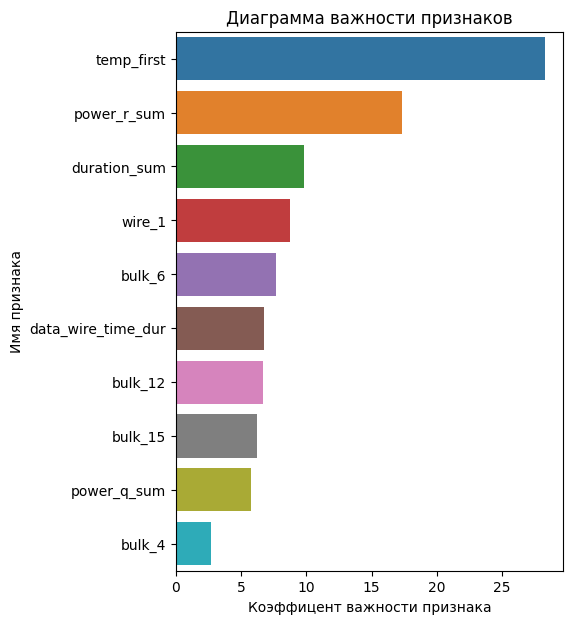

In [109]:
# ploting feature importance
fig, ax = plt.subplots(figsize=(5,7))
plt.xlabel("Коэффицент важности признака")
plt.ylabel("Имя признака")
plt.title('Диаграмма важности признаков')
sns.barplot(ser_features, ser_features.index);

## Отчет

**Введение.**
Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» хочет уменьшить потребление электроэнергии на этапе обработки стали. 

**Цель исследования**: получить модель предсказание температуры стали на последнем этапе обработки.

**Исходные данные.** Было получено 7 датасетов с общим параметром ключ партии. Имена датасетов:
- data_arc.csv — данные об электродах;
- data_bulk.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time.csv — данные о подаче сыпучих материалов (время);
- data_gas.csv — данные о продувке сплава газом;
- data_temp.csv — результаты измерения температуры;
- data_wire.csv — данные о проволочных материалах (объём);
- data_wire_time.csv — данные о проволочных материалах (время).

**Предварительный анализ данных.** 

В первой части исследования были загружены и проанализированы данные. Названия столбцов были приведены к стандартному виду. Выбросы были удалены в случаях: температура ниже 1500 градусов, отрицательная мощность.

Были отобраны ключи в которых присутствует начальная и конечная температуры.

Таблица с мощностью электродов по каждому ключу была преобразована к виду: активная мощность сумарная, активная мощность средняя, реактивная мощность сумарная, реактивная мощность средняя, длительность сумарная, длительность средняя, полная мощность сумарная, полная мощность средняя.

Была проанализирована таблица с подачей сыпучих материалов. Всего 143 варианта подачи сыпучих материалов. Чаще всего используются bulk_12, bulk_14 и bulk_15 вместе или с доплнительными материалами. 50 вариантов подачи использовались только 1 раз.

Была проанализирована таблица газ. Среднее значение газа 11.

Таблица с подачей проволочных материалов. Всего 24 варианта подачи проволных материалов. Чаще всего используются wire_1 самостоятельно или с добавлением wire_2. 5 вариантов подачи использовались только 1 раз.

Таблица со временем подачи сыпучих материалов. Большинство значений разницы во времени между подачей первого материала и последнего лежит между 359 и 906 секунд. В дальнейшем исследовании надо обратить внимание на выбросы в разнице во времени подачи.

Таблица со временем подачи проволочных материалов. Большинство значений разницы во времени между подачей первого материала и последнего лежит между 69 и 658 секунд. В дальнейшем исследовании надо обратить внимание на выбросы в разнице во времени подачи.

**Исследовательский анализ данных.**

В этом разделе исследование данных продолжено на общем датасете. Общий датасет был собран из обработанных исходных датасетов. В итоговый датасет вошли все исходные столбцы из датасетов gas, data_bulk и data_wire. В него вошли преобразованные столбцы из датасета data_ark. Из датасетов data_bulk_time и data_wire_time были добавлены только преобразованные столбцы со временем, между первой и последней загрузкой. ОБъединение было произведено по ключам из преобразованного датасета data_temp. Размер получившегося датасета 2328 х 37.

В продолжение исследования была построена матрица корреляции. Из анализа корреляции видно, что большая часть сгенерированных признауов коррелирует между собой и некоторыми существующими признаками.

Дальше исследование проводилось с помощью инструмента ProfileReport из пакета pandas profiling. Исследование показало малое количество данных в некоторых столбцах датасета. 

**Обработка данных перед подачей в модель.**

Итоговый датасет был разбит на тестовцю и тренировочную выборки в соотношении 1 к 3. Тренировочный датасет был очищен от аномалий при помощи алгоритма Isolation Forest пакета sklearn. 

Далее была проведена подготовка метода предобработки данных для использования в кросс-валидации. Метод включает в себя следующие шаги:
1. Удаление коррелирующих значений
2. Масштабирование признаков при использовании в линейной модели. 
3. Отбор признаков методом KBest. 

**Обучение модели.**

Для кросс-валидации были подготовлены три естиматора: Ридж реггрессия, Случайный лес и CatBoost. Валидация производилась методом RandomizedGridSearch на 5 фолдах. Победила модель CatBoost с результатом мае - {{round(-model.best_score_,2)}}. 

**Проверка на адекватность.**

Для проверки на адекватность использовалась модель DummyReggressor с предсказанием среднего значения по всей выборке. Модель-болванка показала результат {{round(dummy_mae,2)}}. Из этого можно сделать вывод, что победившая модель является адекватной.

**Итоговая проверка модели**

Победившая модель проверяется на тестовой выборке. Итоговое значение мае - {{round(mae_final,2)}} что соответствует отличному результату по техническому заданию. В заключение была построена диаграма важности признаков. 

Самые важные признаки в порядке убывания важности: {{print(\*features_names, sep=' ,', end='.')}}

**Рекомендации.**
При дальнейших исследованиях рекомендуется обратить внимание на комбинацию трех признаков: первое измерение темпреатуры стали, сумарная активная мощность нагрева и сумарная длительность нагрева ковша.






















